Deconvolution Microscopy (Single Channel)
=========================================

This example partially replicates a [GlobalBioIm
example](https://biomedical-imaging-group.github.io/GlobalBioIm/examples.html)
using the [microscopy data](http://bigwww.epfl.ch/deconvolution/bio/)
provided by the EPFL Biomedical Imaging Group.

The deconvolution problem is solved using class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve an image deconvolution problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; \| M (\mathbf{y} - A \mathbf{x})
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} +
  \iota_{\mathrm{NN}}(\mathbf{x}) \;,$$

where $M$ is a mask operator, $A$ is circular convolution,
$\mathbf{y}$ is the blurred image, $C$ is a convolutional gradient
operator, $\iota_{\mathrm{NN}}$ is the indicator function of the
non-negativity constraint, and $\mathbf{x}$ is the desired image.

In [1]:
import scico.numpy as snp
from scico import functional, linop, loss, plot, util
from scico.examples import downsample_volume, epfl_deconv_data, tile_volume_slices
from scico.optimize.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Get and preprocess data. We downsample the data for the for purposes of
the example. Reducing the downsampling rate will make the example slower
and more memory-intensive. To run this example on a GPU it may be
necessary to set environment variables
`XLA_PYTHON_CLIENT_ALLOCATOR=platform` and
`XLA_PYTHON_CLIENT_PREALLOCATE=false`. If your GPU does not have enough
memory, you can try setting the environment variable
`JAX_PLATFORM_NAME=cpu` to run on CPU.

In [2]:
channel = 0
downsampling_rate = 2

y, psf = epfl_deconv_data(channel, verbose=True)
y = downsample_volume(y, downsampling_rate)
psf = downsample_volume(psf, downsampling_rate)

y -= y.min()
y /= y.max()

psf /= psf.sum()

Pad data and create mask.

In [3]:
padding = [[0, p] for p in snp.array(psf.shape) - 1]
y_pad = snp.pad(y, padding)
mask = snp.pad(snp.ones_like(y), padding)

Define problem and algorithm parameters.

In [4]:
λ = 2e-6  # ℓ1 norm regularization parameter
ρ0 = 1e-3  # ADMM penalty parameter for first auxiliary variable
ρ1 = 1e-3  # ADMM penalty parameter for second auxiliary variable
ρ2 = 1e-3  # ADMM penalty parameter for third auxiliary variable
maxiter = 100  # number of ADMM iterations

Create operators.

In [5]:
M = linop.Diagonal(mask)
C0 = linop.CircularConvolve(h=psf, input_shape=mask.shape, h_center=snp.array(psf.shape) / 2 - 0.5)
C1 = linop.FiniteDifference(input_shape=mask.shape, circular=True)
C2 = linop.Identity(mask.shape)

Create functionals.

In [6]:
g0 = loss.SquaredL2Loss(y=y_pad, A=M)  # loss function (forward model)
g1 = λ * functional.L21Norm()  # TV penalty (when applied to gradient)
g2 = functional.NonNegativeIndicator()  # non-negativity constraint

Set up ADMM solver object and solve problem.

In [7]:
solver = ADMM(
    f=None,
    g_list=[g0, g1, g2],
    C_list=[C0, C1, C2],
    rho_list=[ρ0, ρ1, ρ2],
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    x0=y_pad,
    subproblem_solver=CircularConvolveSolver(),
)

print("Solving on %s\n" % util.device_info())
solver.solve()
solve_stats = solver.itstat_object.history(transpose=True)
x_pad = solver.x
x = x_pad[: y.shape[0], : y.shape[1], : y.shape[2]]

Solving on CPU



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.16e+01  2.830e-01  2.780e+02  1.949e+02


  10  2.00e+02  1.033e+00  5.524e+01  9.689e+01


  20  3.83e+02  1.158e+00  7.474e+01  4.940e+01


  30  5.65e+02  1.297e+00  4.547e+01  5.652e+01


  40  7.51e+02  1.528e+00  4.879e+01  3.606e+01


  50  9.35e+02  1.733e+00  3.740e+01  3.763e+01


  60  1.12e+03  1.919e+00  3.390e+01  3.228e+01


  70  1.30e+03  2.133e+00  2.996e+01  2.785e+01


  80  1.48e+03  2.341e+00  2.456e+01  2.723e+01


  90  1.67e+03  2.560e+00  2.437e+01  2.325e+01


  99  1.83e+03  2.754e+00  2.242e+01  2.143e+01


Show the recovered image.

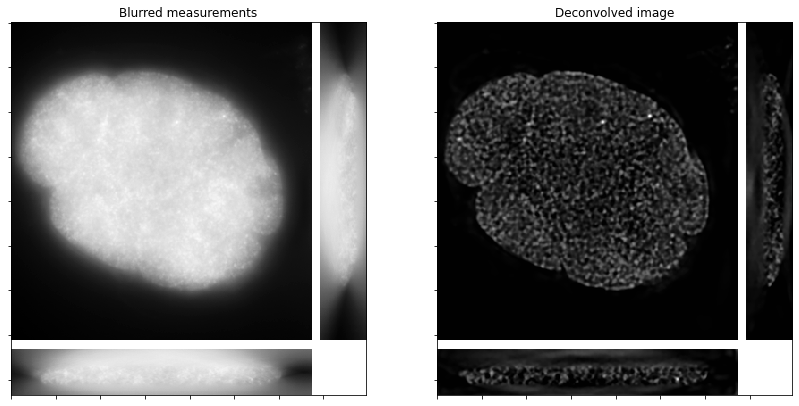

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot.imview(tile_volume_slices(y), title="Blurred measurements", fig=fig, ax=ax[0])
plot.imview(tile_volume_slices(x), title="Deconvolved image", fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

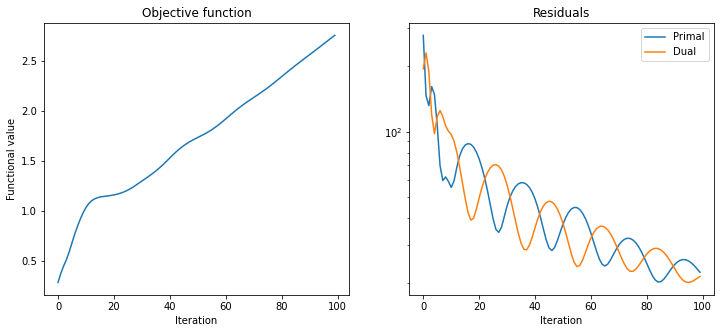

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    solve_stats.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((solve_stats.Prml_Rsdl, solve_stats.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()